# Buiding Vision Transformer on CIFAR 10

## Importing required libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import random
import matplotlib.pyplot as plt

## Setting device

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## Setting hyperparams

In [45]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

batch_size = 128
epochs = 10
learning_rate = 3e-4
patch_size = 4 # segments 
num_classes = 10
image_size = 32
channels = 3
embed_dim = 256
num_heads = 8    # for multi head attention
depth = 6   # means 6 transformer blocks
mlp_dim = 512    # multilinear perceptron layers
drop_rate = .1


## Define Image transformations 

### Data augmentation

In [12]:
from torchvision.transforms import v2

In [17]:
## Transform version 1
transform_v1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.5], [.5]),    # helps the model converge faster and helps to make the numerical computations stable
])

## Getting datasets

In [22]:
train_dataset = datasets.CIFAR10('data', train=True, download=True, transform=transform_v1)
test_dataset = datasets.CIFAR10('data', train=False, download=True, transform=transform_v1)

/home/ilgiz/.cache/pypoetry/virtualenvs/ml-engineering-portfolio-PXL5yKuT-py3.12/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [8]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [9]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

## Converting datasets into dataloaders

In [23]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
print(f"DataLoader: {train_dl, test_dl}")
print(f"Length of train_dl: {len(train_dl)} batches of {batch_size}...")
print(f"Length of test_dl: {len(test_dl)} batches of {batch_size}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x716ef4354140>, <torch.utils.data.dataloader.DataLoader object at 0x716f056c2b40>)
Length of train_dl: 391 batches of 128...
Length of test_dl: 79 batches of 128...


## Building Vision Transformer model from scratch

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)    # projection layer
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))
    
    def forward(self, x: torch.Tensor):
        B = x.size(0)  # batch size
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)

        # Сворачиваем пространственные размерности в одну ось
        x = x.flatten(2)  # (B, embed_dim, num_patches) → flatten(2) = flatten height and width
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim) → меняем местами channels и patches

        # Расширяем cls_token для всего батча
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)

        # Добавляем cls_token в начало
        x = torch.cat((cls_token, x), dim=1)  # (B, 1 + num_patches, embed_dim)

        # Добавляем позиционные эмбеддинги
        x = x + self.pos_embed  # broadcasting работает: (1, 1+N, E) + (B, 1+N, E)

        return x

In [5]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=in_features)
        self.dropout = nn.Dropout(p=drop_rate)
        
    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [6]:
class TransformerEncoderLayer(nn.Module):
       
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()        
        self.norm1 = nn.LayerNorm(embed_dim)    # LayerNorm перед Attention | нормализует каждый токен по признакам (не по батчу!)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)     # Multi-Head Self-Attention (batch_first=True → (B, N, D) формат)
        self.norm2 = nn.LayerNorm(embed_dim)    # LayerNorm перед MLP
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)    # MLP: D → mlp_dim → D
        
    def forward(self, x):
        nx = self.norm1(x)
        x = x + self.attn(nx, nx, nx)[0]     # [0] — только output, без weights, возвращает (output, weights)
        x = x + self.mlp(self.norm2(x))    # MLP с residual connection
        
        return x    # (B, N, embed_dim) — форма сохраняется


In [7]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) — классификация изображений через Transformer.
    Структура: изображение → патчи → [CLS] + позиции → N×EncoderLayer → [CLS] → классы."""
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        
        # 1. Преобразование изображения в последовательность токенов
        #    (B, ch, h, w) ---> (B, 1 + num_patches, embed_dim)
        self.patch_embed = PatchEmbedding(
            img_size, patch_size, in_channels, embed_dim
        )
        
        # 2. Стек из `depth` EncoderLayer'ов
        #    nn.Sequential(*) — распаковка списка слоёв
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        
        # 3. Финальная нормализация перед головой (по аналогии с BERT/ViT)
        self.norm = nn.LayerNorm(embed_dim)  # (B, N, D) → (B, N, D)
        
        # 4. Классификационная голова: только по [CLS] токену
        self.head = nn.Linear(embed_dim, num_classes)  # (B, D) → (B, num_classes)

    def forward(self, x):
        """
        Прямой проход ViT.
        
        Вход:
          x: torch.Tensor — изображения
             форма: (B, C, H, W)
             пример: (8, 3, 224, 224)
        
        Выход:
          logits: torch.Tensor — логиты классов (до softmax)
             форма: (B, num_classes)
             пример: (8, 1000) для ImageNet
        """
        # 1. Patch Embedding: изображение → токены
        #    (B, 3, 224, 224) → (B, 197, 768)  [196 патчей + 1 [CLS]]
        x = self.patch_embed(x)
        
        # 2. Transformer Encoder: глубокая обработка последовательности
        #    (B, 197, 768) → (B, 197, 768)
        x = self.encoder(x)
        
        # 3. Финальная нормализация (обычно есть в ViT)
        #    (B, 197, 768) → (B, 197, 768)
        x = self.norm(x)
        
        # 4. Берём только [CLS] токен (первый в последовательности)
        #    (B, 197, 768) → (B, 768)
        cls_token = x[:, 0]
        
        # 5. Классификация
        #    (B, 768) → (B, num_classes)
        return self.head(cls_token)

## Instantion model

In [13]:
model = VisionTransformer(
    image_size, patch_size, channels, num_classes, embed_dim,
    depth, num_heads, mlp_dim, drop_rate
).to(device)

model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

## Define loss function and optimizer

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)    # lr = 0.0003

optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

## Defining a Training Loop function

In [33]:
def train(model, loader, optimizer, criterion):
    # set the mode of the model into training
    model.train()
    
    total_loss, correct_preds = 0, 0
    
    for batch, targets in loader:
        batch, targets = batch.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # 1. Forward pass (model outputs raw logits)
        out = model(batch)
        
        # 2. Calculate loss (per batch)
        loss = criterion(out, targets)
        
        # 3. Perform backprop
        loss.backward()
        
        # 4. Perform gradient descent
        optimizer.step()
        
        total_loss += loss.item() * batch.size(0)
        correct_preds += (out.argmax(dim=1) == targets).sum().item()
        
    return total_loss / len(loader.dataset), correct_preds / len(loader.dataset)
        

In [34]:
def evaluate(model, loader):
    model.eval()
    total_loss, correct_preds = 0, 0
    
    torch.inference_mode()    # with torch.no_grad()
    for batch, targets in loader:
        batch, targets = batch.to(device), targets.to(device)
        
        out = model(batch)
        loss = criterion(out, targets)
        
        total_loss += loss.item() * batch.size(0)
        correct_preds += (out.argmax(dim=1) == targets).sum().item()
        
    return total_loss / len(loader.dataset), correct_preds / len(loader.dataset)
    

## Training the model

In [21]:
from tqdm.auto import tqdm    # Progress bar

/home/ilgiz/.cache/pypoetry/virtualenvs/ml-engineering-portfolio-PXL5yKuT-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
total_train_acc, total_test_acc = [], []
total_train_loss, total_test_loss = [], []

# epochs = 10

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(model, train_dl, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_dl)
    
    total_train_acc.append(train_acc); total_train_loss.append(train_loss)
    total_test_acc.append(test_acc); total_test_loss.append(test_loss)
    
    print(f"Epoch: {epoch+1}/{epochs} | Train accuracy: {train_acc:.4f}%, Train loss: {train_loss:.4f} | Test accuracy: {test_acc:.4f}%, Test loss: {test_loss:.4f}")

 10%|█         | 1/10 [00:33<04:59, 33.25s/it]

Epoch: 1/10 | Train accuracy: 0.3689%, Train loss: 1.7369 | Test accuracy: 0.4740%, Test loss: 1.4639


 20%|██        | 2/10 [01:05<04:21, 32.70s/it]

Epoch: 2/10 | Train accuracy: 0.5014%, Train loss: 1.3865 | Test accuracy: 0.5356%, Test loss: 1.2907


 30%|███       | 3/10 [01:37<03:47, 32.53s/it]

Epoch: 3/10 | Train accuracy: 0.5529%, Train loss: 1.2449 | Test accuracy: 0.5655%, Test loss: 1.2094


 40%|████      | 4/10 [02:10<03:15, 32.53s/it]

Epoch: 4/10 | Train accuracy: 0.5951%, Train loss: 1.1329 | Test accuracy: 0.5798%, Test loss: 1.1715


 50%|█████     | 5/10 [02:43<02:42, 32.55s/it]

Epoch: 5/10 | Train accuracy: 0.6272%, Train loss: 1.0453 | Test accuracy: 0.5995%, Test loss: 1.1201


 60%|██████    | 6/10 [03:15<02:09, 32.48s/it]

Epoch: 6/10 | Train accuracy: 0.6550%, Train loss: 0.9703 | Test accuracy: 0.6067%, Test loss: 1.1295


 70%|███████   | 7/10 [03:47<01:37, 32.46s/it]

Epoch: 7/10 | Train accuracy: 0.6803%, Train loss: 0.8970 | Test accuracy: 0.6217%, Test loss: 1.0859


 80%|████████  | 8/10 [04:20<01:05, 32.55s/it]

Epoch: 8/10 | Train accuracy: 0.7085%, Train loss: 0.8186 | Test accuracy: 0.6249%, Test loss: 1.0864


 90%|█████████ | 9/10 [04:52<00:32, 32.53s/it]

Epoch: 9/10 | Train accuracy: 0.7348%, Train loss: 0.7466 | Test accuracy: 0.6315%, Test loss: 1.1035


100%|██████████| 10/10 [05:25<00:00, 32.54s/it]

Epoch: 10/10 | Train accuracy: 0.7592%, Train loss: 0.6770 | Test accuracy: 0.6308%, Test loss: 1.1217


In [23]:
total_train_acc, total_test_acc

([0.36894,
  0.50142,
  0.55288,
  0.59512,
  0.62722,
  0.655,
  0.68034,
  0.70846,
  0.73476,
  0.75924],
 [0.474,
  0.5356,
  0.5655,
  0.5798,
  0.5995,
  0.6067,
  0.6217,
  0.6249,
  0.6315,
  0.6308])

In [24]:
total_train_loss, total_test_loss

([1.7369345277404784,
  1.386500238456726,
  1.2448964853286744,
  1.1328673076248168,
  1.0453176041412353,
  0.9702762133598327,
  0.8970160490608216,
  0.8185773624801636,
  0.7465813106155396,
  0.6770056338119507],
 [1.463929372215271,
  1.2907476358413696,
  1.2094418214797973,
  1.1715348024368286,
  1.1201430291175842,
  1.129464157772064,
  1.0858901284217835,
  1.0863810960769653,
  1.10353470287323,
  1.1216852293014525])

## Plot accuracy

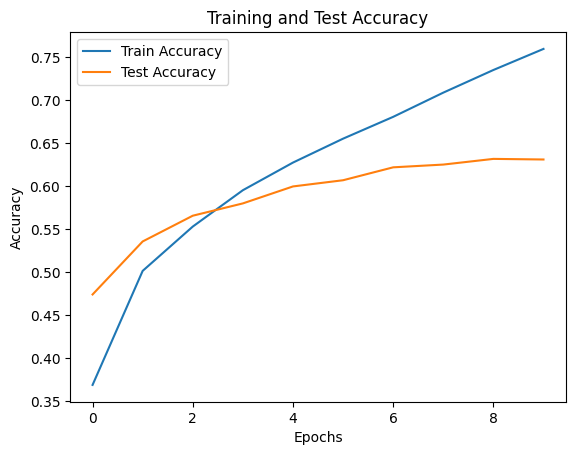

In [25]:
plt.plot(total_train_acc, label="Train Accuracy")
plt.plot(total_test_acc, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [ ]:
# torch.save(model.state_dict(), 'vit_model1.pth')

In [ ]:
model.load_state_dict(torch.load('vit_model1.pth', weights_only=True))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

In [27]:
import random

In [28]:
test_dataset[0][0].shape

torch.Size([3, 32, 32])

## Inference stage, plotting randomly n pictures Version 1

In [29]:
def predict_and_plot_grid(model, dataset, classes, grid_size=3):
    model.eval()  # отключаем dropout/batchnorm для инференса
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))  # создаём сетку 3×3
    
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)  # случайный индекс
            img, true_label = dataset[idx]              # загружаем изображение и метку
            
            input_tensor = img.unsqueeze(0).to(device)  # добавляем batch dim и переносим на device
            
            with torch.inference_mode():  # быстрый режим без градиентов
                out = model(input_tensor)                 # forward pass → logits (1, C)
                _, predicted = torch.max(out, dim=1)      # получаем предсказанный класс (индекс)
            
            img = img / 2 + 0.5           # денормализация: из [-1,1] → [0,1] для отображения
            npimg = img.cpu().numpy()     # в numpy
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))  # (C,H,W) → (H,W,C) для imshow
            
            is_correct = (true_label == predicted.item())  # совпадает ли предсказание?
            color = 'g' if is_correct else 'r'             # зелёный — верно, красный — ошибка
            
            axes[i, j].set_title(
                f'Truth: {classes[true_label]}\nPred: {classes[predicted.item()]}',
                fontsize=10, c=color
            )
            axes[i, j].axis('off')  # убираем оси для чистоты
    
    plt.tight_layout()
    plt.show()

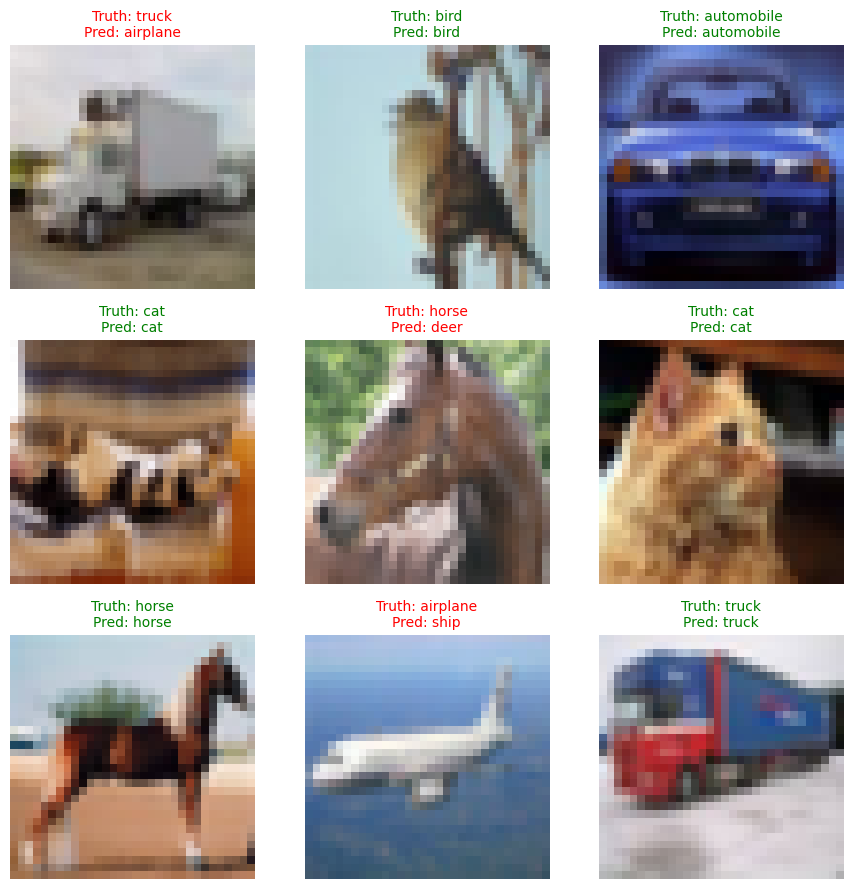

In [30]:
predict_and_plot_grid(model, test_dataset, train_dataset.classes, 3)

In [14]:
model = VisionTransformer(
    image_size, patch_size, channels, num_classes, embed_dim,
    depth, num_heads, mlp_dim, drop_rate).to(device)

model.load_state_dict(torch.load("vit_model1.pth", weights_only=True))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

In [36]:
o1, o2 = test_dataset[0]
train_dataset.classes[o2]

'cat'

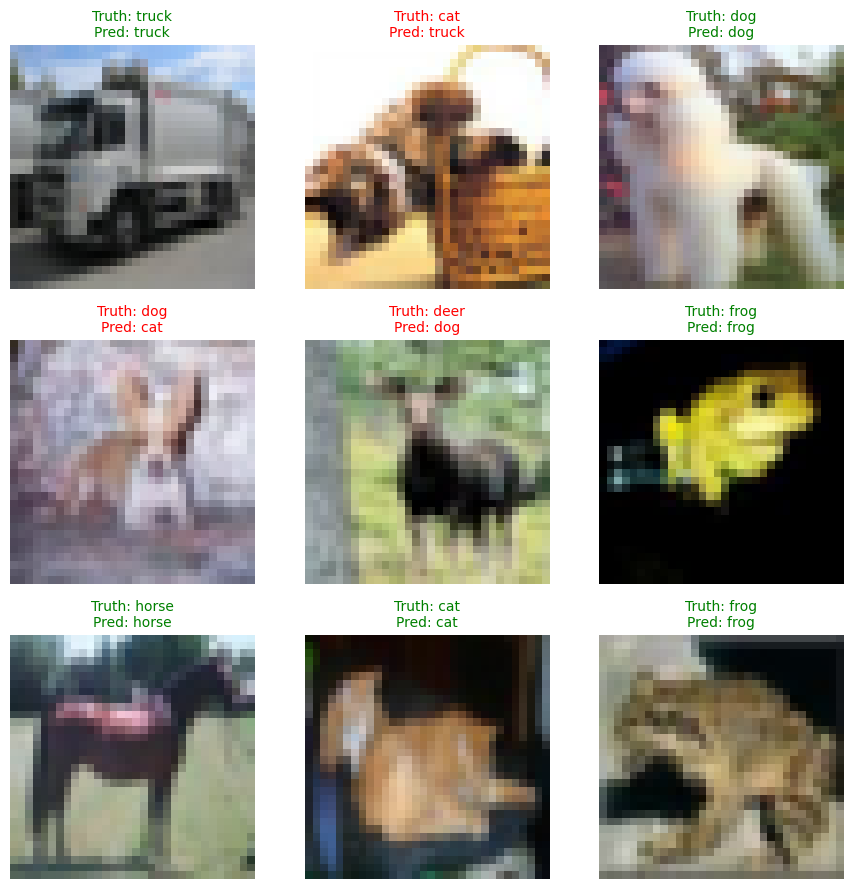

In [37]:
predict_and_plot_grid(model, test_dataset, train_dataset.classes, 3)

## FineTuning and retrain

In [28]:
## Transform version 2
transform_v2 = v2.Compose([
    v2.RandomCrop(size=32, padding=4),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2),
    v2.ToImage(),    # замена ToTensor()
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),    # [.5, .5, .5]
])

In [29]:
train_ds_tv2 = datasets.CIFAR10('data', train=True, download=False, transform=transform_v2)
test_ds_tv2 = datasets.CIFAR10('data', train=False, download=False, transform=transform_v2)

/home/ilgiz/.cache/pypoetry/virtualenvs/ml-engineering-portfolio-PXL5yKuT-py3.12/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [30]:
train_dl_tv2 = DataLoader(train_ds_tv2, batch_size=batch_size , shuffle=True)
test_dl_tv2 = DataLoader(test_ds_tv2, batch_size=batch_size , shuffle=False)

In [31]:
print(f"DataLoader: {train_dl_tv2, test_dl_tv2}")
print(f"Length of train_dl: {len(train_dl_tv2)} batches of {batch_size}...")
print(f"Length of test_dl: {len(test_dl_tv2)} batches of {batch_size}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x716ef4354dd0>, <torch.utils.data.dataloader.DataLoader object at 0x716ef4354c50>)
Length of train_dl: 391 batches of 128...
Length of test_dl: 79 batches of 128...


In [37]:
total_train_acc_v2, total_test_acc_v2 = [], []
total_train_loss_v2, total_test_loss_v2 = [], []

# epochs = 10

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_dl_tv2, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_dl_tv2)
    
    total_train_acc_v2.append(train_acc); total_train_loss_v2.append(train_loss)
    total_test_acc_v2.append(test_acc); total_test_loss_v2.append(test_loss)
    
    print(f"Epoch: {epoch+1}/{epochs} | Train accuracy: {train_acc:.4f}%, Train loss: {train_loss:.4f} | Test accuracy: {test_acc:.4f}%, Test loss: {test_loss:.4f}")

Epoch: 1/10 | Train accuracy: 0.4843%, Train loss: 1.4369 | Test accuracy: 0.5220%, Test loss: 1.3314
Epoch: 2/10 | Train accuracy: 0.5263%, Train loss: 1.3188 | Test accuracy: 0.5396%, Test loss: 1.2861
Epoch: 3/10 | Train accuracy: 0.5510%, Train loss: 1.2592 | Test accuracy: 0.5617%, Test loss: 1.2242
Epoch: 4/10 | Train accuracy: 0.5657%, Train loss: 1.2160 | Test accuracy: 0.5775%, Test loss: 1.1769
Epoch: 5/10 | Train accuracy: 0.5792%, Train loss: 1.1741 | Test accuracy: 0.5792%, Test loss: 1.1874
Epoch: 6/10 | Train accuracy: 0.5920%, Train loss: 1.1398 | Test accuracy: 0.5960%, Test loss: 1.1275
Epoch: 7/10 | Train accuracy: 0.6048%, Train loss: 1.1076 | Test accuracy: 0.5918%, Test loss: 1.1367
Epoch: 8/10 | Train accuracy: 0.6120%, Train loss: 1.0830 | Test accuracy: 0.6153%, Test loss: 1.0802
Epoch: 9/10 | Train accuracy: 0.6266%, Train loss: 1.0455 | Test accuracy: 0.6263%, Test loss: 1.0592
Epoch: 10/10 | Train accuracy: 0.6351%, Train loss: 1.0232 | Test accuracy: 0.6340

In [ ]:
# torch.save(model.state_dict(), 'vit_model2.pth')

In [39]:
from PIL import Image
import io

In [47]:
image = Image.open('cat_test.jpg')

transform_inference = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[.5, .5, .5], std=[.5, .5, .5]
    )
])

image_tensor = transform_inference(image)
image_tensor = image_tensor.unsqueeze(0) # [3, 32, 32] -> [1, 3, 32, 32]
image_tensor = image_tensor.to(device)

model.eval()
with torch.inference_mode():
    logits = model(image_tensor)
    probs = torch.softmax(logits, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()
    print(cifar10_classes[pred_class])

cat
